## Speech to Text

### Download Dataset

Source : https://voice.mozilla.org/en/datasets

In [0]:
!wget https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-3/en.tar.gz # englisth dataset

--2019-12-11 03:00:42--  https://voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com/cv-corpus-3/en.tar.gz
Resolving voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)... 54.231.176.218
Connecting to voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com (voice-prod-bundler-ee1969a6ce8178826482b88e843c335139bd3fb4.s3.amazonaws.com)|54.231.176.218|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30159205077 (28G) [application/octet-stream]
Saving to: ‘en.tar.gz’

en.tar.gz           100%[===================>]  28.09G  29.0MB/s    in 16m 5s  

2019-12-11 03:16:47 (29.8 MB/s) - ‘en.tar.gz’ saved [30159205077/30159205077]



In [0]:
#!rm -rf /content/English
!rm -rf /content/English/train_data
!rm -rf /content/English/test_data

In [0]:
!mkdir /content/English
!tar -C /content/English -xf /content/en.tar.gz

In [0]:
!ls /content/English/clips/ -F |grep -v / | wc -l

896823


### Preprocessing

In [1]:
# let's listen to a few audios
import os
import random
import re
import string
import IPython
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

!pip install torchviz
!pip install torchaudio

import torch
import datetime
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchaudio
from torchaudio.transforms import Spectrogram
from torchviz.u
# import warnings
# warnings.filterwarnings("ignore")

     |████████████████████████████████| 2.7MB 2.8MB/s 
     |████████████████████████████████| 773.1MB 21kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1


In [0]:
# Process and save Common Voice dataset
cv_dir = os.path.join('/content')
chars = ['_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', ' ']
tokens = [i for i in range(len(chars))]
tokenize_dict = {c:t for c,t in zip(chars, tokens)}
token_to_char = {t:c for c,t in tokenize_dict.items()}

print(tokenize_dict)
print(token_to_char)

{'_': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, ' ': 27}
{0: '_', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 27: ' '}


In [0]:
def process_sent(s):
    s = s.lower()
    s = s.translate(str.maketrans('', '', string.punctuation))
    return ','.join([tokenize_dict[c] for c in s])



def parse_df(df, lan, lang_dir, save_dir):
    """
        Extracts audio and sentence from df
        Returns new df with columns
            "clip" (indexed names)
            "sentence" (corresponding target sentence)
    """
    data = []
    clips_dir = os.path.join(lang_dir, 'clips')
    i = 0
    for clip, sent in zip(df.path, df.sentence):
        try:    # some audio files may not exist
            nums = re.findall(r'\d+', sent)
            if len(nums)==0: # avoiding numbers from target sentences
                clip_name = f'{lan}_{i}.mp3'
                src = os.path.join(clips_dir, clip)
                dst = os.path.join(save_dir, clip_name)
                copyfile(src, dst)
                data.append((clip_name, process_sent(sent)))
                i += 1 # update counter
        except FileNotFoundError:
            pass 
        except TypeError:
            pass
        except KeyError: # for characters such as ú
            pass
    data_df = pd.DataFrame(data, columns=['clip', 'sentence'])
    return data_df


    
if __name__ == "__main__":
    lang_dir = os.path.join('English', 'clips')
    train_dir = 'train_data'
    test_dir = 'test_data'

    # load dataframes
    train_df = pd.read_csv(os.path.join(lang_dir, 'train.tsv'),  delimiter='\t')
    dev_df = pd.read_csv(os.path.join(lang_dir, 'dev.tsv'),  delimiter='\t')
    train_df = pd.concat([train_df, dev_df])
    test_df = pd.read_csv(os.path.join(lang_dir, 'test.tsv'),  delimiter='\t')

    # Extract train data
    print('Preparing Train dataset')
    train_data_df = parse_df(train_df, 'eng', lang_dir, train_dir) # extract data from train_df 
    train_data_df.to_csv(os.path.join(train_dir, 'train_data.csv'))

    # Extract test data
    print('Preparing test dataset')
    test_data_df = parse_df(test_df, 'eng', lang_dir, test_dir) # extract data from test_df
    test_data_df.to_csv(os.path.join(test_dir, 'test_data.csv')) # save

In [0]:
!ls /content/English/train_data/ -F |grep -v / | wc -l
!ls /content/English/test_data/ -F |grep -v / | wc -l

74759
12851


### Make dataset

### Analyze the dataset

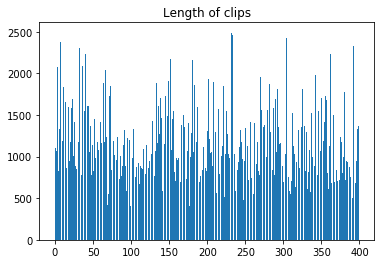

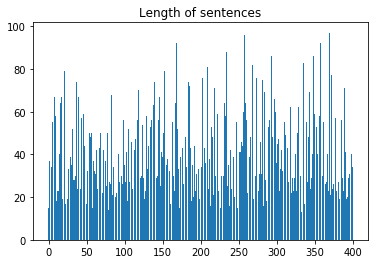

In [0]:
x_lens = []
sent_lens = []

cur_test_data_df = test_data_df.iloc[2400:2800]
trial_dataset = SpeechDataset(cur_test_data_df, test_dir)

for idx in range(cur_test_data_df.shape[0]):
    x, t = trial_dataset.__getitem__(idx, pad=False)    
    x_lens.append(x.shape[2])
    sent_lens.append(len(t))
    
x_axis = np.arange(idx+1)
plt.bar(x_axis, x_lens)
plt.title("Length of clips")
plt.show()
plt.bar(x_axis, sent_lens)
plt.title("Length of sentences")
plt.show()

### Cleaning the dataset
- Deleting unncecessarily long audio clips or sentences.

In [0]:
def remove_long_examples(df, dir, max_spec_len, max_sent_len):
    new_samples = []
    trial_dataset = SpeechDataset(df, dir)

    for idx in range(df.shape[0]):
        x, sent = trial_dataset.__getitem__(idx, pad=False)    
        if x.shape[2] < max_spec_len and len(sent) < max_sent_len:
            new_samples.append((df['clip'].iloc[idx], df['sentence'].iloc[idx]))
    return pd.DataFrame(new_samples)

In [0]:
MAX_DATA_LEN = 2500
MAX_SENT_LEN = 100
new_test_data _df = remove_long_examples(test_data_df, test_dir, MAX_DATA_LEN, MAX_SENT_LEN)
new_train_data_df = remove_long_examples(train_data_df, train_dir, MAX_DATA_LEN, MAX_SENT_LEN)
# save the dataset
new_test_data.to_csv('/content/drive/My Drive/Datasets/new_test_data.csv')
new_tain_data.to_csv('/content/drive/My Drive/Datasets/new_train_data.csv')

#### Upload the created dataset to drive 

In [0]:
# creata a file list
!cd /content/English/train_data/ && printf '%s\n' * > /content/train_files.txt
!cd /content/English/test_data/ && printf '%s\n' * > /content/test_files.txt
# compress the dataset
!tar -c -C /content/English/train_data/ -T train_files.txt -f /content/train_data.tar.gz 
!tar -c -C /content/English/test_data/ -T test_files.txt -f /content/test_data.tar.gz 
# delete the extra files
!rm /content/*.txt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!mv /content/train_data.tar.gz /content/drive/My\ Drive/Datasets/train_data.tar.gz
!mv /content/test_data.tar.gz /content/drive/My\ Drive/Datasets/test_data.tar.gz

## Download dataset from Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# # Download dataset from drive
!cp /content/drive/My\ Drive/Datasets/train_data.tar.gz /content/train_data.tar.gz
!cp /content/drive/My\ Drive/Datasets/test_data.tar.gz /content/test_data.tar.gz
# create dirs

!mkdir /content/train_data
!mkdir /content/test_data
# # Extracts the dataset
!tar -C /content/train_data -xf /content/train_data.tar.gz
!tar -C /content/test_data -xf /content/test_data.tar.gz
# confirm the number of audio clips
!ls /content/train_data/ -F |grep -v / | wc -l
!ls /content/test_data/ -F |grep -v / | wc -l

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
74759
12851


In [0]:
# make dirs
train_dir = '/content/train_data'
test_dir = '/content/test_data'
# # dataframes
datasets = '/content/drive/My Drive/Datasets/'
test_data_df = pd.read_csv(os.path.join(datasets, 'new_test_data.csv'),skiprows=[0], 
                           header=None, names=['index', 'clip', 'sentence'])
train_data_df = pd.read_csv(os.path.join(datasets, 'new_train_data.csv'),skiprows=[0], 
                            header=None, names=['index', 'clip', 'sentence'])
                           

In [0]:
!rm -rf /content/train_data
!rm -rf /content/test_data

In [0]:
# checking the authenticity of the dataset
idx = 40055
tokens = train_data_df['sentence'].iloc[idx].split(',')
sent = []
for t in tokens:
    sent.append(token_to_char[int(t)])
print('Spoken sentence:', ''.join(sent))
IPython.display.Audio(os.path.join(train_dir, train_data_df['clip'].iloc[idx]))

Spoken sentence: the brown and white dog is playing in the snow


### Checking torchaudio

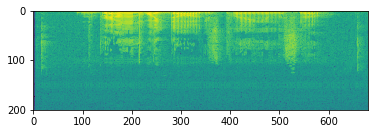

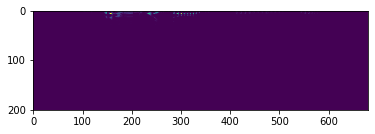

In [0]:
idx = 40055
filename = os.path.join(train_dir, train_data_df['clip'].iloc[idx])
waveform, sample_rate = torchaudio.load(filename)
x = torchaudio.transforms.Spectrogram()(waveform)
xl = torch.log2(x)
plt.imshow(xl[0,:,:])
plt.show()
plt.imshow(x[0,:,:])
IPython.display.Audio(filename)

In [0]:
# some max and mins
print(x.max(), x.min())
print(xl.max(), xl.min())

tensor(964.0245) tensor(0.)
tensor(9.9129) tensor(-inf)


Hence, the log function does it's job of reducing the positive numbers, but 
exponentially increasing decimal values, and 0.

tensor(964.0245) tensor(0.)


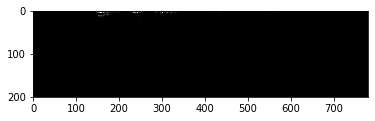

log2 then padding
tensor(9.9129) tensor(-inf)


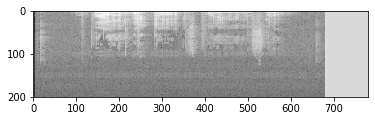

padding then log2
tensor(9.9129) tensor(-50.)


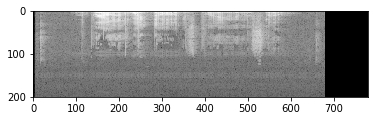

In [0]:
x_pad = torch.zeros_like(x)
X = torch.cat((x, x_pad[:,:,:100]), dim=2)
print(X.max(), X.min())
plt.imshow(X[0,:,:], cmap='gray')
plt.show()


print("log2 then padding")
xl_pad = torch.zeros_like(xl)
Xl = torch.cat((xl, xl_pad[:,:,:100]), dim=2)
print(Xl.max(), Xl.min())
plt.imshow(Xl[0,:,:], cmap='gray')
plt.show()

print("padding then log2")
x_pad_log = X.log2().clamp(min=-50)
print(x_pad_log.max(), x_pad_log.min())
plt.imshow(x_pad_log[0,:,:], cmap='gray')

tensor(1.) tensor(-0.8766) tensor(-2.9899e-07)
tensor(0.7291) tensor(-0.8766)


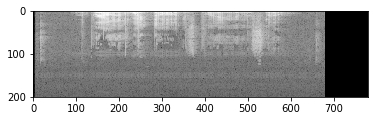

In [0]:
def normalize(tensor):
    # Subtract the mean, and scale to the interval [-1,1]
    tensor_minusmean = tensor - tensor.mean()
    return tensor_minusmean/tensor_minusmean.abs().max()

x_norm = normalize(x_pad_log)
print(x_norm.max(), x_norm.min(), x_norm.mean())
plt.imshow(x_norm[0,:,:], cmap='gray')
print(x_norm[0,0,180], x_norm[0,0,720])

### Dataset

In [0]:
class SpeechDataset(Dataset):
    def __init__(self, df, data_dir, max_target_len=-1, max_data_len=-1):
        self.df = df
        self.data_dir = data_dir
        self.specgram = Spectrogram()
        self.max_data_len = max_data_len
        self.max_target_len = max_target_len
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx, pad=True):
        # preparing audio data
        filename = os.path.join(self.data_dir, self.df['clip'].iloc[idx])
        waveform, sample_rate = torchaudio.load(filename)
        x = self.specgram(waveform)

        # preparing target
        sent = self.df['sentence'].iloc[idx]
        sent = list(map(int, sent.split(',')))
        
        if pad:
            input_length = x.shape[2]
            x = F.pad(x, (0,self.max_data_len-x.shape[2]), "constant", 0)

            X = x.log2().clamp(min=-50) # avoid log(0)=-inf
            # Normalize input
            X = (X - X.mean())
            X = X/X.abs().max()

            # pad target
            target_length = len(sent)
            target = F.pad(torch.tensor(sent), (0, self.max_target_len-len(sent)), 'constant', 0)
            return (X, target, input_length, target_length)
        else:
            return (x, sent)


In [0]:
idx = 100
trial = SpeechDataset(train_data_df, train_dir, 100, 2500)
x, y, _, _ = trial.__getitem__(idx)
y.shape

torch.Size([100])

### Model

In [0]:
class ASRNetwork(nn.Module):
    def __init__(self, input_len, hidden_size, num_layers, output_shape, bidirectional):
        super(ASRNetwork, self).__init__()
        self.lstm = nn.LSTM(input_len, hidden_size, num_layers=num_layers, bidirectional=bidirectional)
        self.linear = nn.Linear(hidden_size*2 if bidirectional else hidden_size, output_shape) # output shape = num possible chracters
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, x):
        """
            input shape : (batch_size, 1, 201, 2500)
            lstm input shape: (2500, batch_size, 201) # (seq_len, bs, input_len) 
            lstm output shape: (2500, batch_size, hidden_size) # hidden state from each timestep
            time distributed linear layer output: (2500, batch_size, output_size)
        """
        x, _ = self.lstm(x.flatten(start_dim=1, end_dim=2).permute(2, 0, 1))
        x = self.softmax(self.linear(x))
        return x

### Training

In [0]:
def train(model, device, train_loader, optimizer, epoch, log_interval):
    model.train()
    print('Training')
    date1 = datetime.datetime.now()
    for batch_idx, (data, target, in_len, tgt_len) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        in_len, tgt_len = in_len.to(device), tgt_len.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.ctc_loss(output, target, in_len, tgt_len)  # default blank token : 0
        loss.backward()
        optimizer.step()    
        if batch_idx % log_interval == 0:
            date2 = datetime.datetime.now()
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t time {}:'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item(), date2 - date1))
            date1 = date2


def test(model, device, test_loader, log_interval):
    model.eval()
    loss = 0
    print('-'*10, '\nTesting')
    date1 = datetime.datetime.now()
    for batch_idx, (data, target, in_len, tgt_len) in enumerate(test_loader):
        data, target = data.to(device), target.to(device)
        in_len, tgt_len = in_len.to(device), tgt_len.to(device)
        output = model(data)
        loss += F.ctc_loss(output, target, in_len, tgt_len).detach().item()  # default blank token : 0
        if batch_idx % log_interval == 0:
            date2 = datetime.datetime.now()
            print('Train Epoch: [{}/{} ({:.0f}%)]\t time {}:'.format(
                batch_idx * len(data), len(test_loader.dataset),
                100. * batch_idx / len(test_loader), date2 - date1))
            date1 = date2
    return loss/len(test_loader)


In [0]:
def check_on_personal(model, device, idx, dataset):
    x, target, _, _ = dataset.__getitem__(idx) 
    output, (h,c) = model(x[None,:,:,:].to(device))
    h.detach()
    c.detach()
    sent = []
    for t in target:
        sent.append(token_to_char[int(t)])
    print('Spoken sentence:', ''.join(sent))

    word = []
    for t in range(output.shape[0]):
        chars = output[t,0,:]
        cur_char = token_to_char[torch.argmax(chars).item()]
        if cur_char != "_":
            word.append(cur_char)
    print('Outptut:', ''.join(word))

### Dataloaders and Datasets

In [0]:
max_data_len = 2500
max_sent_len = 100

train_dataset = SpeechDataset(train_data_df, train_dir, max_data_len, max_sent_len)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = SpeechDataset(test_data_df, test_dir, max_data_len, max_sent_len)
test_loader = DataLoader(test_dataset, batch_size=128)

### Generate graph

In [0]:
device = torch.device("cuda")
input_len = 201
hidden_size = 50
num_layers = 2
output_shape = 28
bidirectional = False
model = ASRNetwork(input_len, hidden_size, num_layers, output_shape, bidirectional).to(device)

torch.Size([5, 1, 28])


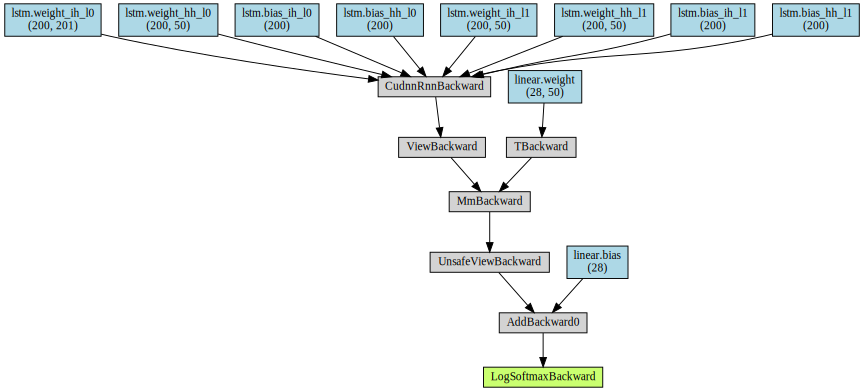

In [18]:
from torchviz import make_dot
x = torch.rand((1, 1, 201, 5)).to(device)
y = model(x)
print(y.shape)
make_dot(y, params=dict(model.named_parameters()))

### Training

In [0]:
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# optimizer = optim.Adam(model.parameters())
optimizer = optim.Adadelta(model.parameters())

epochs = 10
log_interval = 10


for epoch in range(1, epochs):
    train(model, device, train_loader, optimizer, epoch, log_interval)
    torch.save(model.state_dict(), f'model_new_{epoch}')
    val_loss = test(model, device, test_loader)
    print('Validation loss', val_loss)
    check_on_personal(model, device, random.randint(0, 100), train_dataset)

Training
Train Epoch: 1 [0/69228 (0%)]	Loss: 36.108807 time 0:00:03.890295:
Train Epoch: 1 [1280/69228 (2%)]	Loss: 8.832026 time 0:00:38.355401:
Train Epoch: 1 [2560/69228 (4%)]	Loss: 10.039211 time 0:00:38.631248:
Train Epoch: 1 [3840/69228 (6%)]	Loss: 9.448002 time 0:00:39.015585:
Train Epoch: 1 [5120/69228 (7%)]	Loss: 10.704736 time 0:00:38.713857:
Train Epoch: 1 [6400/69228 (9%)]	Loss: 9.862583 time 0:00:39.292961:
Train Epoch: 1 [7680/69228 (11%)]	Loss: 9.602838 time 0:00:38.822153:
Train Epoch: 1 [8960/69228 (13%)]	Loss: 10.579557 time 0:00:38.310142:
Train Epoch: 1 [10240/69228 (15%)]	Loss: 12.318927 time 0:00:38.381811:
Train Epoch: 1 [11520/69228 (17%)]	Loss: 10.844959 time 0:00:38.525090:
Train Epoch: 1 [12800/69228 (18%)]	Loss: 15.209230 time 0:00:38.202910:
Train Epoch: 1 [14080/69228 (20%)]	Loss: 14.671561 time 0:00:38.830109:
Train Epoch: 1 [15360/69228 (22%)]	Loss: 11.757694 time 0:00:38.748954:
Train Epoch: 1 [16640/69228 (24%)]	Loss: 11.418887 time 0:00:38.835924:
Trai

## Testing

In [0]:
### Testing on personal data
wav_path = '/content/train_data/eng_1.mp3'
IPython.display.Audio(wav_path)

In [0]:
waveform, sample_rate = torchaudio.load(wav_path)
x = torchaudio.transforms.Spectrogram()(waveform)[None,:,:,:]
x = x.to(device)        
output = model(x)
print(output.shape)

word = []
for t in range(output.shape[0]):
    chars = output[t,0,:]
    cur_char = token_to_char[torch.argmax(chars).item()]
    word.append(cur_char)optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
print(word)

torch.Size([1523, 1, 28])
['_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'

### Save stuff to drive

In [0]:
from google.colab import drive
drive.flush_and_unmount()